# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm
tqdm.pandas()

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
#from nltk.corpus import stopwords

In [2]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
import re
import time

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

## Подготовка

### Загрузка данных.
На данном этапе проведем загрузку данных и их общую информацию. Сделаем вывод по полученным данным.

In [5]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [6]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

In [7]:
display(data.head(10))

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [8]:
print('количество строк в данных: ',data.shape[0])
print('количество дубликатов в данных: ',data.duplicated().sum())
print('Процентное соотношение:',format(round(data.duplicated().sum() / data.shape[0] * 100, 2)), '%')
print('количество пропусков в данных:\n',data.isna().sum())

количество строк в данных:  159292
количество дубликатов в данных:  0
Процентное соотношение: 0.0 %
количество пропусков в данных:
 text     0
toxic    0
dtype: int64


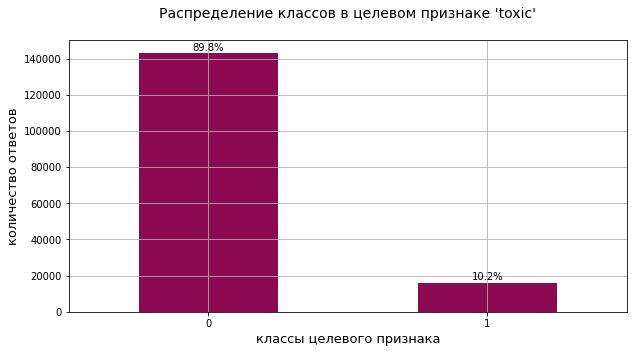

In [9]:
plt.figure(figsize=[10,5])

ax = data['toxic'].value_counts().plot.bar( color = '#8B0A50');
plt.title ("Распределение классов в целевом признаке 'toxic'\n", fontsize=14)
plt.xlabel('классы целевого признака', fontsize=13)
plt.xticks(rotation=0);
plt.ylabel('количество ответов', fontsize=13)
plt.grid(True)

for p in ax.patches:
        percentage = f'{100 * p.get_height() / len(data):.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')

### ВЫВОД:
Была проведена загрузка данных из файла toxic_comments.csv. При чтении файла был прописан параметр index_col=0. Была проведена проверка на пропуски и дубликаты. Они отсутствуют. Был просмотрен целевой признак, 90% занимают положительные отзывы, остальные - отрицательные.

### Предобработка текстовых данных.
На данном этапе будет выполнена токенизация каждого текста и его лемматизированние. 

In [10]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
nltk.download('punkt');
m = WordNetLemmatizer();

def lemmatize(text) :
    text = text.lower()
    word_list = nltk.word_tokenize(text)
    lemm_list = [m.lemmatize(w, get_wordnet_pos(w)) for w in word_list]
    lemm_text = " ".join(lemm_list)
    
    return lemm_text

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
def clear_text (text) :
   # text_1 = re.sub(r'[^a-zA-Z ]',' ', text)
    text_1 = re.sub(r"[^a-zA-Z']", ' ', text)
    clear = " ".join(text_1.split())
    
    return clear

In [13]:
#проверка
sentence = "The striped bats are hanging on their feet for best"
sentence = lemmatize(clear_text(sentence))
print("the strip bat be hang on their foot for best" )
print(sentence)

the strip bat be hang on their foot for best
the strip bat be hang on their foot for best


In [14]:
data['text'] = data ['text'].progress_apply(clear_text).progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

  0%|          | 0/159292 [00:00<?, ?it/s]

In [15]:
display(data.head(10))

,text,toxic
0,explanation why the edits make under my userna...,0
1,d'aww he match this background colour i 'm see...,0
2,hey man i 'm really not try to edit war it 's ...,0
3,more i ca n't make any real suggestion on impr...,0
4,you sir be my hero any chance you remember wha...,0
5,congratulation from me a well use the tool wel...,0
6,cocksucker before you piss around on my work,1
7,your vandalism to the matt shirvington article...,0
8,sorry if the word 'nonsense ' be offensive to ...,0
9,alignment on this subject and which be contrar...,0


In [16]:
print('Явные дубликаты:',data.duplicated().sum())
print('Процентное соотношение:',format(round(data.duplicated().sum() / data.shape[0] * 100, 2)), '%')

Явные дубликаты: 1261
Процентное соотношение: 0.79 %


In [17]:
data.drop_duplicates(inplace=True)
print('Проверка на явные дубликаты после их удаления:',data.duplicated().sum())
print('Новое количество строк:', data.shape[0])

Проверка на явные дубликаты после их удаления: 0
Новое количество строк: 158031


### Вывод: 
Была совершена обработка текстовых данных. Были проведены токенезация и лемматизация. Лемматизация даных проведена с помощью WordNetLemmatizer()( Mystem работал очень медленно). После предобработки была проведена повторная проверка на дубликаты. Обнаружено меньше 1%. Было принято решение их удалить.

## Обучение

### Подготовка данных
На данном этапе будет проходить разделение данных на выборки и проверка на разделение матриц.

In [18]:
corpus = data['text'].values

In [19]:
features = corpus
target = data['toxic']
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=TEST_SIZE,random_state=42)

In [20]:
print(
    f'Выборка разделена в пропорциях:\n'
    f'{(len(X_train)/len(data)):.0%} — тренировочная;\n'
    f'{(len(X_test)/len(data)):.0%} — тестовая;\n'
)

Выборка разделена в пропорциях:
90% — тренировочная;
10% — тестовая;



In [21]:
print(
    f'Размер матриц:\n'
    f'{X_train.shape[0], y_train.shape[0]} — тренировочная;\n'
    f'{X_test.shape[0], y_test.shape[0]} — тестовая;\n'
)

Размер матриц:
(142227, 142227) — тренировочная;
(15804, 15804) — тестовая;



#### ВЫВОД: 
Данные разделены в соотношении 90 на 10. В треннировочных и тестовых данных наблюдаются различия по матрицам, при обучении необходимо будет воспользоваться балансом.

### ОБУЧЕНИЕ ДАННЫХ

####  Модель ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

In [22]:
pipe_lir = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                       ('lir', LogisticRegression(solver='liblinear', class_weight = 'balanced', random_state=RANDOM_STATE))])
parameters_lir = {
    'lir__C': range(8,10), 
    'lir__max_iter': [500],  
}

lir_grid = GridSearchCV(pipe_lir, parameters_lir, scoring='f1', cv=3,  verbose=True, n_jobs=-1, error_score = 'raise')

In [23]:
%%time

lir_grid.fit(X_train, y_train)

lir_fit_score = lir_grid.best_score_
print('Лучшая модель и её параметры:', lir_grid.best_estimator_)
print(f'Лучший показатель F1: {lir_fit_score:.2f}')

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Лучшая модель и её параметры: Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                ('lir',
                 LogisticRegression(C=8, class_weight='balanced', max_iter=500,
                                    random_state=42, solver='liblinear'))])
Лучший показатель F1: 0.76
CPU times: user 2min 15s, sys: 1min 14s, total: 3min 30s
Wall time: 3min 30s


#### Модель DecisionTreeClassifier

In [24]:
pipe_tree = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                       ('tree', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])
parameters_tree = {
    'tree__max_depth': list(range(20,25))  
}

tree_grid = GridSearchCV(pipe_tree, parameters_tree, scoring='f1', cv=3, n_jobs=-1, error_score = 'raise')

In [25]:
%%time

tree_grid.fit(X_train, y_train)
tree_fit_score = tree_grid.best_score_
print('Лучшая модель и её параметры:', tree_grid.best_estimator_)
print(f'Лучший показатель F1: {tree_fit_score:.2f}')

Лучшая модель и её параметры: Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                ('tree',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=24,
                                        random_state=42))])
Лучший показатель F1: 0.63
CPU times: user 5min 8s, sys: 179 ms, total: 5min 8s
Wall time: 5min 8s


#### Модель RandomForestClassifier

In [26]:
pipe_random = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                       ('random', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced',verbose=False ))])
parametrs_random = { 'random__n_estimators': list(range(90,100,150)),
                     'random__max_depth': (None, *range(1,10))
                   }
random_grid = GridSearchCV(pipe_random, parametrs_random, scoring='f1', cv=3, n_jobs=-1, error_score = 'raise' )

In [27]:
%%time

random_grid.fit(X_train, y_train)
random_fit_score = random_grid.best_score_
print('Лyчшая модель и её параметры:', random_grid.best_estimator_)
print(f'Лучший показатель F1: {random_fit_score:.2f}')

Лyчшая модель и её параметры: Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                ('random',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=90, random_state=42,
                                        verbose=False))])
Лучший показатель F1: 0.64
CPU times: user 42min 27s, sys: 2.01 s, total: 42min 29s
Wall time: 42min 33s


#### Вывод.
Данные были обучены на трёх моделях: LogisticRegression, DecisionTreeClassifier и RandomForestClassifier.
Точность больше 0.75 показала модель LogisticRegression (0.762) с параметрами C=8, class_weight='balanced', max_iter=500, random_state=42, solver='liblinear'. На данной моели будет проведено тестирование.

### Тестирование

In [28]:
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                       ('lir', LogisticRegression(solver='liblinear', class_weight = 'balanced', random_state=RANDOM_STATE))])
parameters_lir = {
    'lir__C': [8], 
    'lir__max_iter': [500],  
}

In [30]:
predictions = lir_grid.predict(X_test)
lir_f1 = f1_score(y_test, predictions)

#predictions = pipe_lir.predict(X_test)
#lir_f1 = f1_score(y_test, predictions)

print(f'Показатель F1 на тренировочной выборке: {lir_f1:.2f}')

Показатель F1 на тренировочной выборке: 0.75


#### Вывод
Проверка на тестовых данных модель LogisticRegression показала результат  0.75, что удовлетворяет требованию поставленной задачи.

## Выводы

Была поставлена задача в обучении модели классифицировать комментарии на позитивные и негативные. При этом построенная  модель должна иметь метрику метрики качества *F1* не меньше 0.75. 

Для решения задачи было сделано:

- Была проведена загрузка данных из файла toxic_comments.csv. При чтении файла был прописан параметр index_col=0. Была проведена проверка на пропуски и дубликаты. Они отсутствуют. Был просмотрен целевой признак, 90% занимают положительные отзывы, остальные - отрицательные.

- Была совершена обработка текстовых данных. Были проведены токенезация и лемматизация. Лемматизация даных проведена с помощью WordNetLemmatizer()( Mystem работал очень медленно). После предобработки была проведена повторная проверка на дубликаты. Обнаружено меньше 1%. Было принято решение их удалить.

- На этапе подготовки даннных к обучению, они были разделены в соотношении 90 на 10. В треннировочных и тестовых данных наблюдаются различия по матрицам, при обучении необходимо будет воспользоваться балансом.

- Данные были обучены на трёх моделях: LogisticRegression, DecisionTreeClassifier и RandomForestClassifier.Точность больше 0.75 показала модель LogisticRegression (0.762) с параметрами C=8, class_weight='balanced', max_iter=500, random_state=42, solver='liblinear'. На данной моели будет проведено тестирование.

- Проверка на тестовых данных модель LogisticRegression показала результат  0.75, что удовлетворяет требованию поставленной задачи.